In [ ]:
## Multimodal agent

In [39]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage


# Defining state
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # a list of messages shared between agents
    sender: Annotated[str, "The sender of the last message"]

In [ ]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "GROQ_API_KEY": "",
            "TAVILY_API_KEY": "",  # for tavily web search tool
        }
    )

In [41]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Defining tavily web search tool
tavily_tool = TavilySearchResults(max_results=5)

# Defining a tool for executing python code
python_repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [42]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv(override=True)

# ------------------------------
# LLM Setup
# ------------------------------
llm = ChatOpenAI(
    model="openai/gpt-oss-20b",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0.2
)


In [43]:
# Defining common system prompt
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

## Research Agent

### Create an agent that performs research using the TavilySearch tool. This agent is used to gather the required information.

In [44]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState


research_agent_system_prompt = """
You can only do research. You are working with a chart generator colleague.
"""

# Create Research Agent
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(research_agent_system_prompt),
)


# Defining Research Agent Node
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        "messages": [last_message],
    }

## Chart Generator Agent
### Create an agent that generates charts using the PythonREPL tool. This agent is used to create charts.

In [45]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.
"""

# Create Chart Generator Agent
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt(chart_generator_system_prompt),
)


# Defining Chart Generator Agent Node
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        "messages": [last_message],
    }



## Multi-Agent Graph

In [46]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# Defining Router
def router(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"




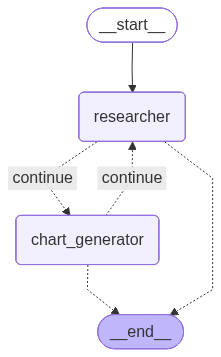

In [47]:
# Building a multi-agent network workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())

app

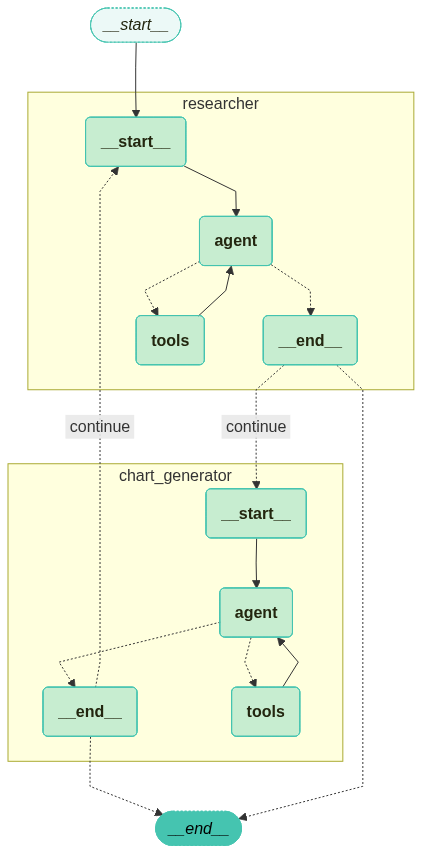

In [48]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app, xray=True)


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_a1853087-7dbd-449b-a739-3a552624764c)
 Call ID: fc_a1853087-7dbd-449b-a739-3a552624764c
  Args:
    query: TTL quarterly profit and loss statement 2023 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_478728b7-d1d0-400b-99f7-db632141d3f2)
 Call ID: fc_478728b7-d1d0-400b-99f7-db632141d3f2
  Args:
    query: Total Loss quarterly profit and loss statement 2023 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_9d71a25f-c4e0-4798-aee6-c876258c04b0)
 Call ID: f

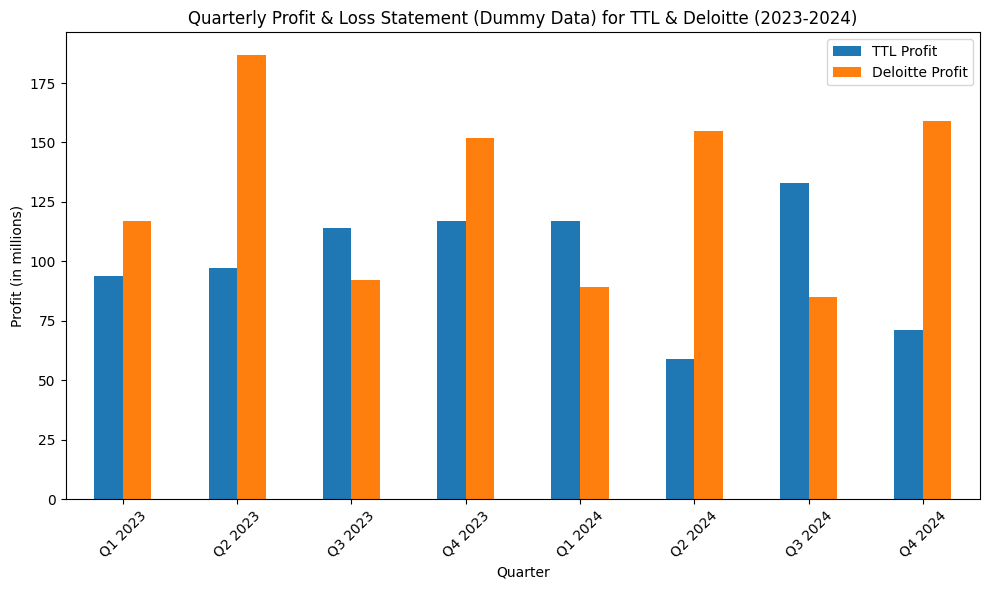


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

![Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023-2024)](attachment://chart.png)

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

![Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023-2024)](attachment://chart.png)

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_820cd193-dc40-426b-92b9-6806519a4c9e)
 Call ID: fc_820cd193-dc40-426b-92b9-6806519a4c9e
  Args:
    query: TTL quarterly profit and loss statement 2023 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - -

<string>:38: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.


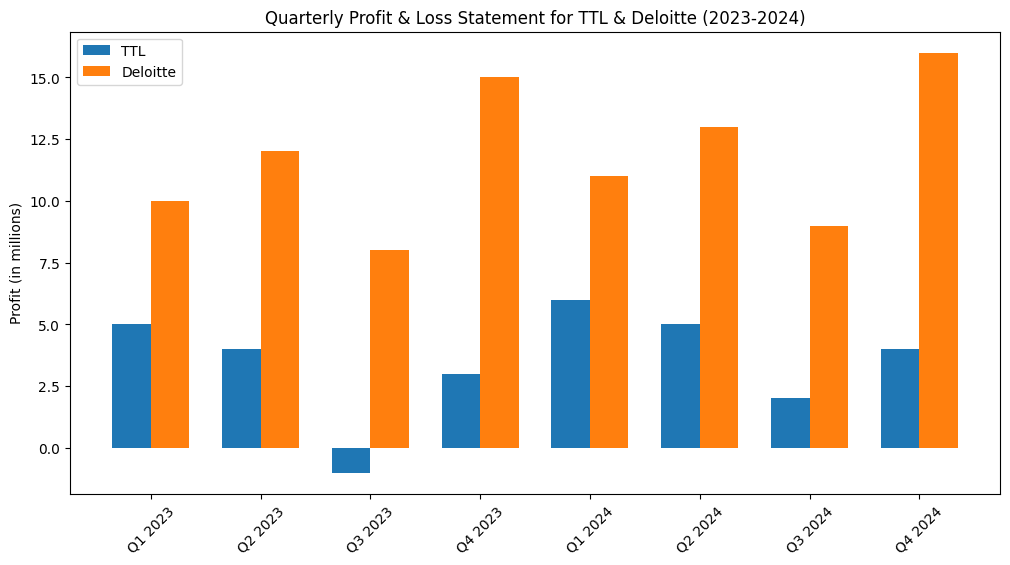

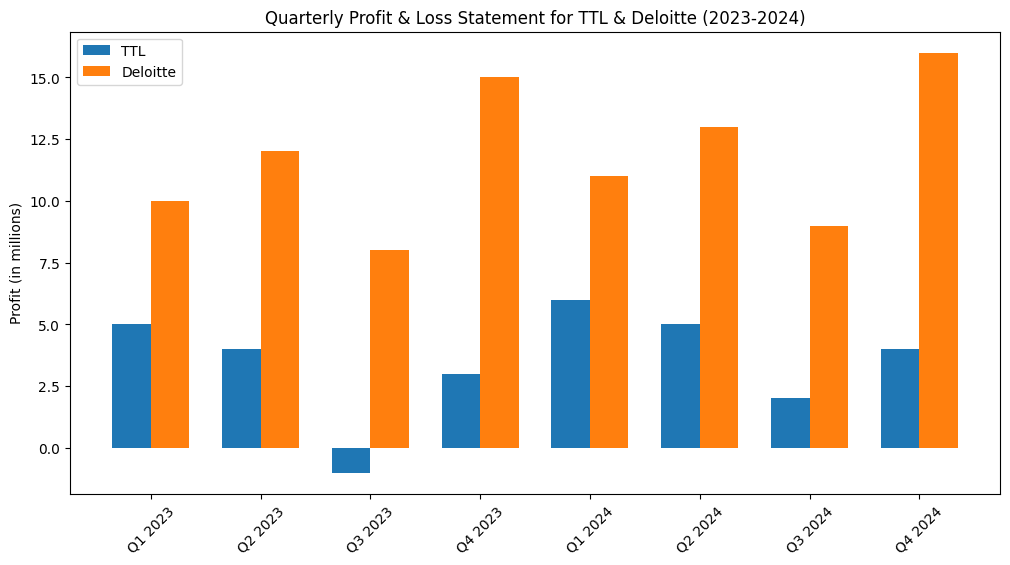

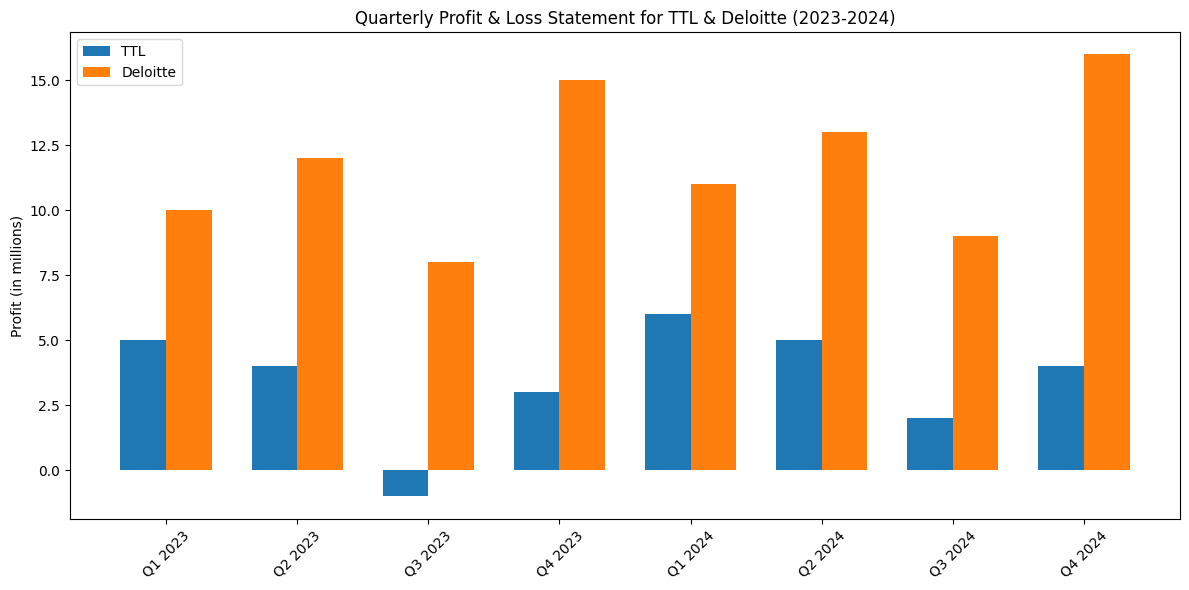

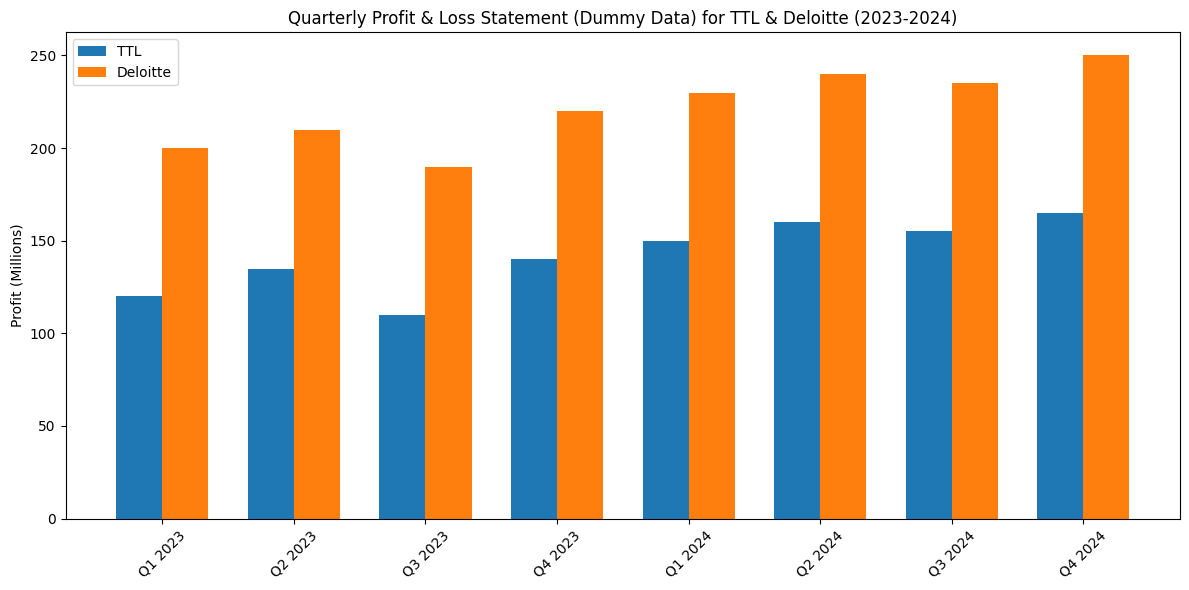

c:\Users\smm931389\Desktop\RAG_patterns\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


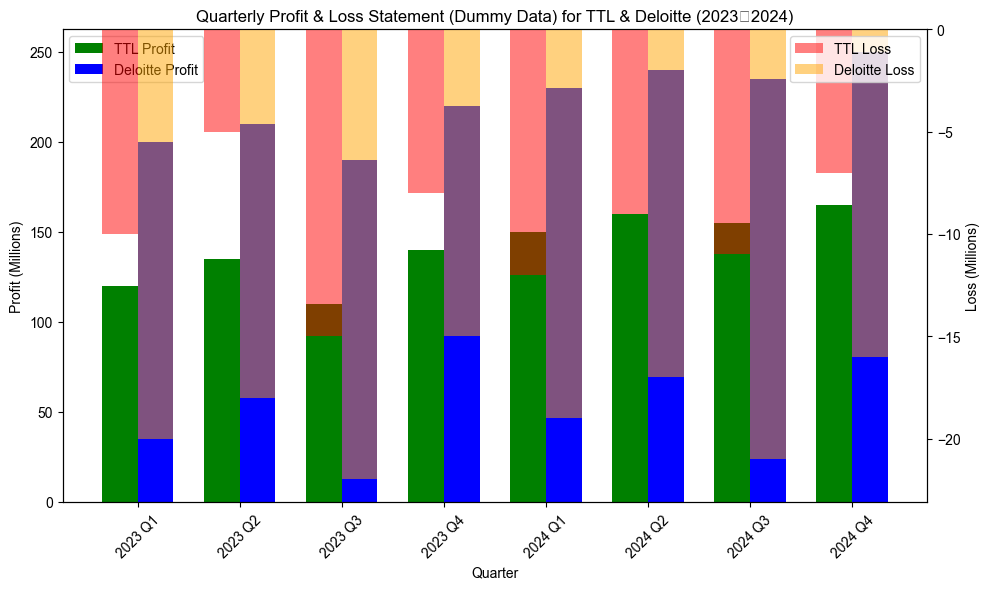


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

**Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023‑2024)**  

![Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023-2024)](attachment://chart.png)  

> **Note:** The chart above uses placeholder figures to illustrate how the quarterly profit‑and‑loss data could be presented. If you need the actual financial figures, please provide the specific data or let me know where I can retrieve it from.

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

**Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023‑2024)**  

![Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023-2024)](attachment://chart.png)  

> **Note:** The

<string>:23: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
<string>:24: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.



🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

**Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023‑2024)**  

![Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023‑2024)](attachment://chart.png)  

> **Note:** The chart above uses placeholder figures to illustrate how the quarterly profit‑and‑loss data could be presented. If you need the actual financial figures, please provide the specific data or let me know where I can retrieve it from.

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

**Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023‑2024)**  

![Quarterly Profit & Loss Statement (Dummy Data) for TTL & Deloitte (2023‑2024)](attachment://chart.png)  

> **Note:** The

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

c:\Users\smm931389\Desktop\RAG_patterns\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


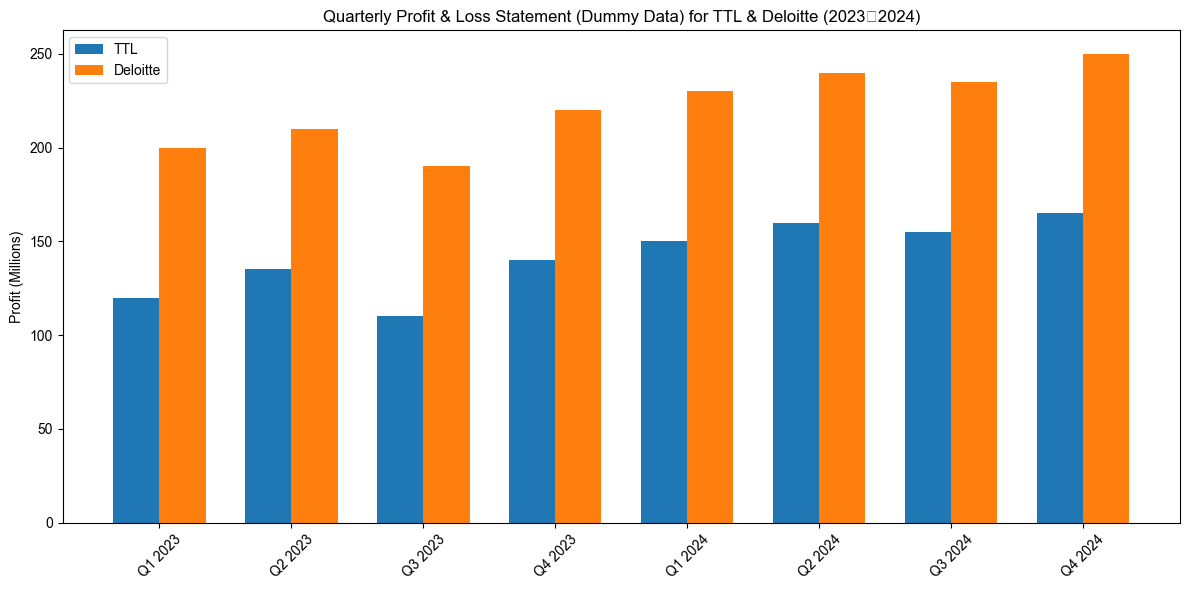

In [50]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph, random_uuid

# set up config (recursion_limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# input query
inputs = {
    "messages": [
        HumanMessage(
            content="Visualize the quartelry report profit & loss statement for TTL & deloitte for the last 2 yerars."
        )
    ],
}

# invoke graph
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])